In [162]:
import math
import numpy as np
import scipy as sp
from scipy import signal
from scipy.io import wavfile
import scipy.io
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

In [163]:
file = scipy.io.wavfile.read('signal.wav')

In [164]:
# Sample rate is the number of samples per second
print("The sample rate is the following: ", file[0])

The sample rate is the following:  16000


In [165]:
print("The number of samples in the recording is: ", len(file[1]))

The number of samples in the recording is:  18091


In [166]:
print("Therefore, it corresponds to the following seconds:", len(file[1])/file[0])

Therefore, it corresponds to the following seconds: 1.1306875


In [168]:
# Mean subtraction:
data = np.array(file[1])
mean = np.mean(data)
data_mean = data - mean

In [169]:
# Pre-emphasis:
data_w_pre = data_mean
data_w_pre = np.zeros(len(data))
data_w_pre[0] = data_mean[0]
b = 0.97
for i in range(1, len(data)):
    data_w_pre[i] = data_mean[i] - b * data_mean[i - 1]

In [173]:
# Computing frames:
def computing_frames(data, L, S):
    d = len(data)
    rows = (len(data) - L) // S + 2 if (len(data) - L) % S != 0 else (len(data) - L) / S + 1
    cols = int(L)
    matrix = [[0]*(cols) for _ in range(rows)]
    for i in range(rows):
        for j in range(cols):
            if i * S + j < d:
                matrix[i][j] = data[i * S + j]
            else:
                matrix[i][j] = 0
    return np.array(matrix)

In [174]:
# Applying the window function to the matrix:
def hamming_window(matrix):
    # len of the frame, it should be iqual to L as states the previous function
    n = len(matrix[0])
    window = np.array(signal.windows.hamming(n))
    ans = [[0]*(n) for _ in range(len(matrix))]
    # get the hamming window as np array
    for i in range(len(matrix)):
        ans[i] = matrix[i] * window
    return np.array(ans)


In [175]:
# Computing the Fourier transform, magnitude spectrum and power spectrum:
# n = 512 by default which is the number of DFT points N we want to compute
def compute_fft(matrix, n):
    # number of frames
    m = len(matrix)
    dft = np.zeros((m, n), dtype = complex)
    dft_mag = np.zeros((m, n))
    dft_pow = np.zeros((m, n))
    for i in range(m):
        dft[i] = scipy.fft.fft(matrix[i], n)
        dft_mag[i] = np.abs(dft[i])
        dft_pow[i] = np.square(dft_mag[i])
    return dft, dft_mag, dft_pow

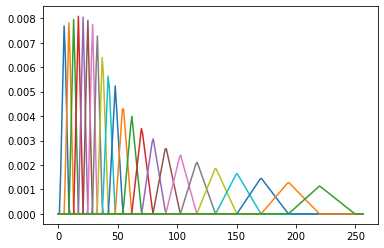

In [176]:
# Load Mel filters
mel_filters = np.load('mel_filters.npy')
# Filterbanks plot:
plt.plot(mel_filters.T)

In [177]:
print(np.shape(mel_filters))

(23, 257)


In [178]:
# Computing the Mel-filterbank considering the slicing and traspose of dft_pow
def mel_filterbank(mel_filters, dft_pow):
    # matrix with 23 rows and 112 columns
    dft_mel = np.matmul(mel_filters, dft_pow)
    return dft_mel

In [179]:
def taking_log(dft_mel):
    dft_log = np.zeros((len(dft_mel), len(dft_mel[0])))
    for i in range(len(dft_mel)):
        for j in range(len(dft_mel[0])):
            dft_log[i][j] = max(-50, np.log(dft_mel[i][j]))
    return dft_log

In [180]:
def computing_DCT_filtering(dft_log, DCT):
    C = np.zeros((DCT, len(dft_log[0])))
    print(len(dft_log[0]))
    print(len(dft_log))
    for i in range(DCT):
        for j in range(len(dft_log)):
            x = (np.pi * i / 23) * (j + 0.5)
            C[i] += dft_log[j] * np.cos(x)
    np.shape(C)
    return C

In [194]:
# Window lenght or frame length times the number of samples per second (sample rate) gives us 
# L number of samples to use for each kth frame, therefore we can get L as follows:

L = 0.025
L = int(L * file[0])

# Frame shift or hop times the number of samples per second (sample rate) gives us
# S samples that will form our k rows, therefore we can get S as follows:

S = 0.010
S = int(S * file[0])

# Number of DFT points
N = 512

# number of DCT coeeficients to be calculated
DCT = 13

In [195]:
print(len(data_w_pre))
print(L)
print(S)
frame_matrix = computing_frames(data_w_pre, L, S)
print("Number of rows i.e. N_f or k frames: ", len(frame_matrix)) # ex: 112 = (samples - (L - 1))/K + 1
print("Number of frames in each kth element: ", len(frame_matrix[0])) # ex: 400 = L
window_matrix = hamming_window(frame_matrix)
dft, dft_mag, dft_pow = compute_fft(window_matrix, N)

18091
400
160
Number of rows i.e. N_f or k frames:  112
Number of frames in each kth element:  400


In [196]:
# Mel-filterbank application
# Slicing the matrix to get the first 257 elements of each row
slice_window = int(N // 2 + 1)
dft_pow_positive = dft_pow[:,0:slice_window]
# Transpose matrix to multiply with mel filters
dft_pow_positive_t = dft_pow_positive.T
# Obtaining new matrix with mel filters
dft_mel = mel_filterbank(mel_filters, dft_pow_positive_t)
# Taking the log
dft_log = taking_log(dft_mel)
# computing the DCT and filtering
C = computing_DCT_filtering(dft_log, DCT)
# slicing C
C_2 = np.delete(C, 0, 0)

112
23


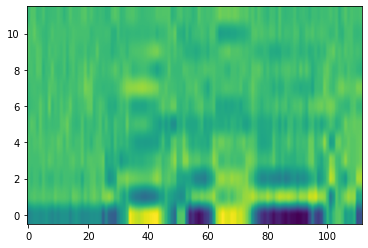

In [184]:
plt.imshow(C_2, aspect = 'auto', origin='lower')

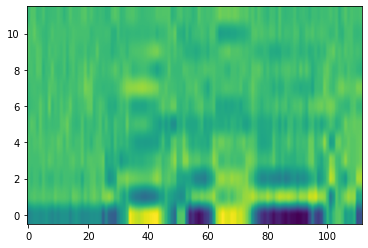

In [185]:
reference_mfcc = np.load('reference_mfcc.npy').T
reference_mfcc_2 = np.delete(reference_mfcc, 0, 0)
plt.imshow(reference_mfcc_2, aspect = 'auto', origin='lower')

In [187]:
# Computing the difference between ours and reference
matrix_difference = np.zeros((len(C), len(C[0])))
MSE = np.zeros(len(C))
for i in range(len(C)):
    for j in range(len(C[0])):
        matrix_difference[i][j] = reference_mfcc[i][j] - C[i][j]
    MSE[i] = np.square(np.subtract(reference_mfcc[i],C[i])).mean()
# The MSE considering all the 13 coeeficients is:
total_MSE = MSE.mean()
print("The MSE considering all the 13 coeeficients is:", total_MSE)

The MSE considering all the 13 coeeficients is: 2.072730944868064e-26


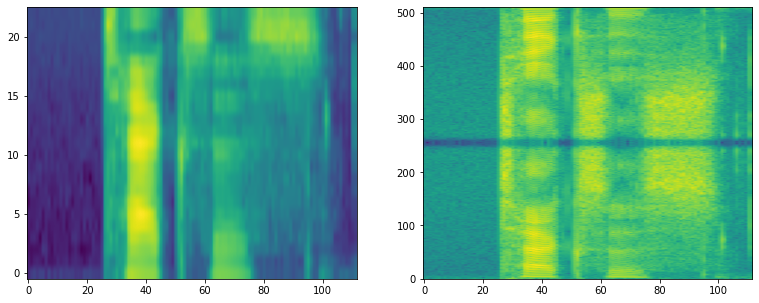

In [188]:
# obtaining the log power spectrum
dft_pow_spectrum = taking_log(dft_pow.T)
np.shape(dft_pow_spectrum)
fig = plt.figure(figsize=(13, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(dft_log, aspect = 'auto', origin='lower')
fig.add_subplot(1, 2, 2)
plt.imshow(dft_pow_spectrum, aspect = 'auto', origin='lower')
# TODO: Comment on how these two spectra look different, and include both plots in your writeup.
# Compare to X_(logpow) we can see that X_(logmel) is exagerated in low frequencies and compressed in high frequencies
# i.e. high resolution in low frequencies and low in high. This is because X_(logmel) sum up the energies underneath
# each triangular filter in the Mel Filter Banks instead of using the magnitude/energy spectrum as we see in X_(logpow).
# The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies 
# and less discriminative at higher frequencies. Finally, in X_(logmel) we have highly correlated inputs so we can use
# them if the machine learning algorithm is not susceptible to highly correlated input.

In [189]:
# Second part, changing parameters:
# Window lenght or frame length times the number of samples per second (sample rate) gives us 
# L number of samples to use for each kth frame, therefore we can get L as follows:

L = 0.004
L = int(L * file[0])

# Frame shift or hop times the number of samples per second (sample rate) gives us
# S samples that will form our k rows, therefore we can get S as follows:

S = 0.001
S = int(S * file[0])

# Number of DFT points
N = 512

# number of DCT coeeficients to be calculated
DCT = 13

In [190]:
frame_matrix = computing_frames(data_w_pre, L, S)
print("Number of rows i.e. N_f or k frames: ", len(frame_matrix)) # ex: 112 = (samples - (L - 1))/K
print("Number of frames in each kth element: ", len(frame_matrix[0])) # ex: 400 = L
window_matrix = hamming_window(frame_matrix)
dft, dft_mag, dft_pow = compute_fft(window_matrix, N)

Number of rows i.e. N_f or k frames:  1128
Number of frames in each kth element:  64


In [191]:
# Mel-filterbank application
# Slicing the matrix to get the first 257 elements of each row
slice_window = int(N // 2 + 1)
dft_pow_positive = dft_pow[:,0:slice_window]
# Transpose matrix to multiply with mel filters
dft_pow_positive_t = dft_pow_positive.T
# Obtaining new matrix with mel filters
dft_mel = mel_filterbank(mel_filters, dft_pow_positive_t)
# Taking the log
dft_log = taking_log(dft_mel)
# computing the DCT and filtering
C = computing_DCT_filtering(dft_log, DCT)
# slicing C
C_2 = np.delete(C, 0, 0)

1128
23


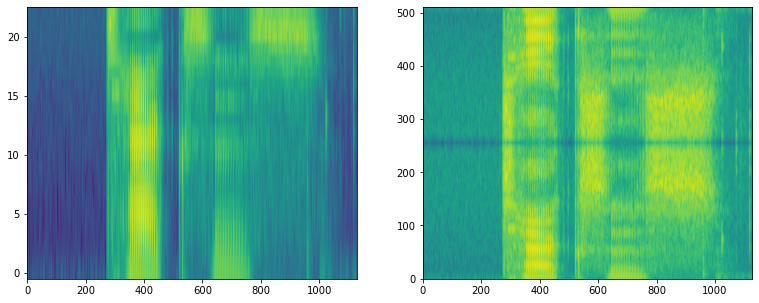

In [192]:
# obtaining the log power spectrum
dft_pow_spectrum = taking_log(dft_pow.T)
np.shape(dft_pow_spectrum)
fig = plt.figure(figsize=(13, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(dft_log, aspect = 'auto', origin='lower')
fig.add_subplot(1, 2, 2)
plt.imshow(dft_pow_spectrum, aspect = 'auto', origin='lower')
# Compare to the previous plot with higher windows length, in the graph with shorter window lenght
# we can see a better resolution in time, as we discussed in lecture this happens because of the tradeoff between
# frequency resolution and time resolution. I.e. longer window will give us more oscillations captured means a better
# frequency resolution, but poorer time resolurion. On the other hand, shorter windows gives u poorer frequency
# resolution, but better time resolution. This is often called the time-frequency "uncertainty principle" in signal
# processing.

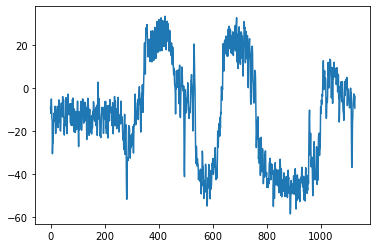

In [193]:
# Plot of C[1] considering L=4ms and S=1ms
plt.plot(C[1])
# We can see the function has a lower values for fricatives than vowels, this is because vowels have a higher overall
# energy level. On the other hand, fricatives are caracterized for a constriction in the vocal tract that makes them
# more turbulent, fricatives contain more high-frequency noise components. These characteristics leads to a 
# lower overall energy level compared to vowels. 

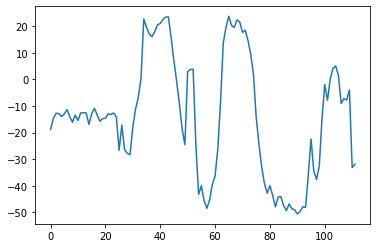

In [197]:
# Plot of C[1] considering L=25ms and S=10ms
plt.plot(C[1])

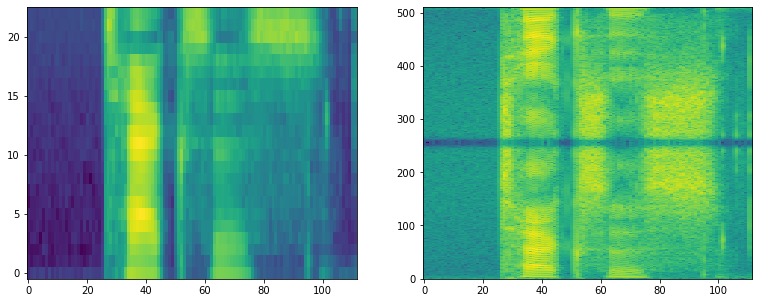

In [198]:
# obtaining the log power spectrum
dft_pow_spectrum = taking_log(dft_pow.T)
np.shape(dft_pow_spectrum)
fig = plt.figure(figsize=(13, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(dft_log, aspect = 'auto', origin='lower', interpolation='nearest')
fig.add_subplot(1, 2, 2)
plt.imshow(dft_pow_spectrum, aspect = 'auto', origin='lower', interpolation='nearest')
# TODO: Comment on how these two spectra look different, and include both plots in your writeup.

In [77]:
np.shape(C[1])
print(len(dft_log))

23


In [107]:
def computing_cosine(dft_log, DCT):
    cosine = np.zeros(len(dft_log))
    for j in range(len(dft_log)):
        x = (math.pi * 1 / 23) * (j + 0.5)
        cosine[j] = np.cos(x)
    return cosine

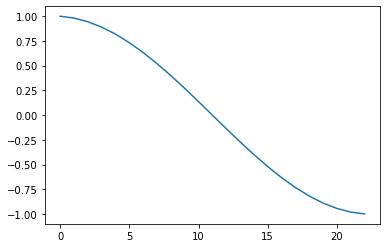

In [113]:
cosine = computing_cosine(dft_log, DCT)
plt.plot(cosine)

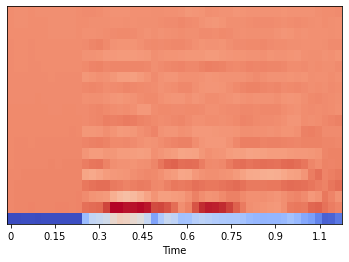

In [149]:
import librosa
x, sr = librosa.load('signal.wav')

mfccs = librosa.feature.mfcc(y=x, sr=sr)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

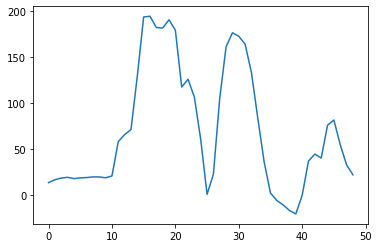

In [118]:
plt.plot(mfccs[1])